# Capitulo 7 - Modelos de espaço estado para séries temporais

Os modelos de espaço estados pressupoem um mundo no qual o estado verdadeiro não pode ser diretamente calculado, temos apenas uma inferencia do que pode ser medido. Também, esse modelos dependem da especifição da dinamica de uma sistema, por exemplo, como o verdadario estado do mundo evolui ao longo do tempo, devido a dinamica interna e as forças externas aplicadas a um sistema.


In [2]:
library(forecast)
library(tseries)
library(data.table)
library(zoo)

## Prós e contras

Os modelos de espaço estados podem ser **utilizados para aplicações deterministicas e estocasticas**, como em amostras continuas e amostras discretas de dados.

Um MEE tem muitas apectos positivos, no quais:
1. O processo dinamico e os estados que geram os dados ruidosos que estão sendo analisados, em vez de apenas os proprios dados ruidosos.
2. Permite a mudança de coeficientes e parametros ao longo do tempo, significando que possibilita a mudança de comportamento ao longo do tempo.
3. **Não é necessario impor uma condição de estacionariedade aos nossos dados quando usamos o MEE.**

Contudo, nem tudo são flores MEE possui suas desvantagens:
1. São muitos flexiveis 
    * Alta quantidade de parametros
        * Risco de overfiting
    * Muitas formas o modelo pode assumir

2. Baixa documentação sobre tais modelos
3. Bem pesados computacionamentes

## Filtro de Kalman

É uma metodo avançado e bastante implementado para incorporar novas informações de uma série temporal e integralas de maneira inteligente com informações  previamente conhecidas para estimar um estado subjacente. 

* Facilidade do calculo
* Não exige armazenamento de dados anteriores

### Visão Geral

$$
x_t = F \cdot x_{t-1} + B \cdot U_t + w_t \\
y_t = A \cdot x_t + v_t
$$
> Modelo linear gaussiano

O estado no tempo $t$ é a função do estado no intervalo anterior de tempo $F \cdot x_{t-1} $, um termo de forma externa $ B \cdot U_t $ e um termo estocatico  $ w_t $


Vamos imaganer que

* $x_t$ é a posição real de uma nave espacial
* $y_t$ é a posição que medimos com um sensor
* $v_t$ é o error da medição em nosso dispositivos sensor.

A seguinte equação fund. e aplicavel ao filtro de kalman ilustra como atualizar nossas estimativas dada a novas informação para o tempo $t$

$$
\^x_t = K \cdot y_{t} + (1-K) \cdot \^x_t 
$$

* $P_t$ é a estimativa da covariancia de nosso estado
* $P^-_t$  é a estimativa de $t$ antes de nossa medida no tempo $t$ ser leveda em consideração

### Código para filtro de kalman

Geraremos uma série temporal com base nas Leis de Newton, ou seja, a posição de um objeto é uma função de sua velocidade e aceleração.

In [13]:
## Foquete levará 100 intervalos
ts.length = 100

## Aceleração conduzira o modevimento
a = rep(0.5, ts.length)

In [8]:
## Posição e velocidade começam em 0.
x = rep(0, ts.length)
v = rep(0, ts.length)

In [14]:
for (i in 2:ts.length) {
  x[i] = v[i-1]*2 + x[i - 1] + 0.5 * a[i-1]^2;
  x[i] = x[i] + rnorm(1, sd = 20) ## componente estocasticos
  v[i] = v[i-1] + 2 * a[i - 1]
}

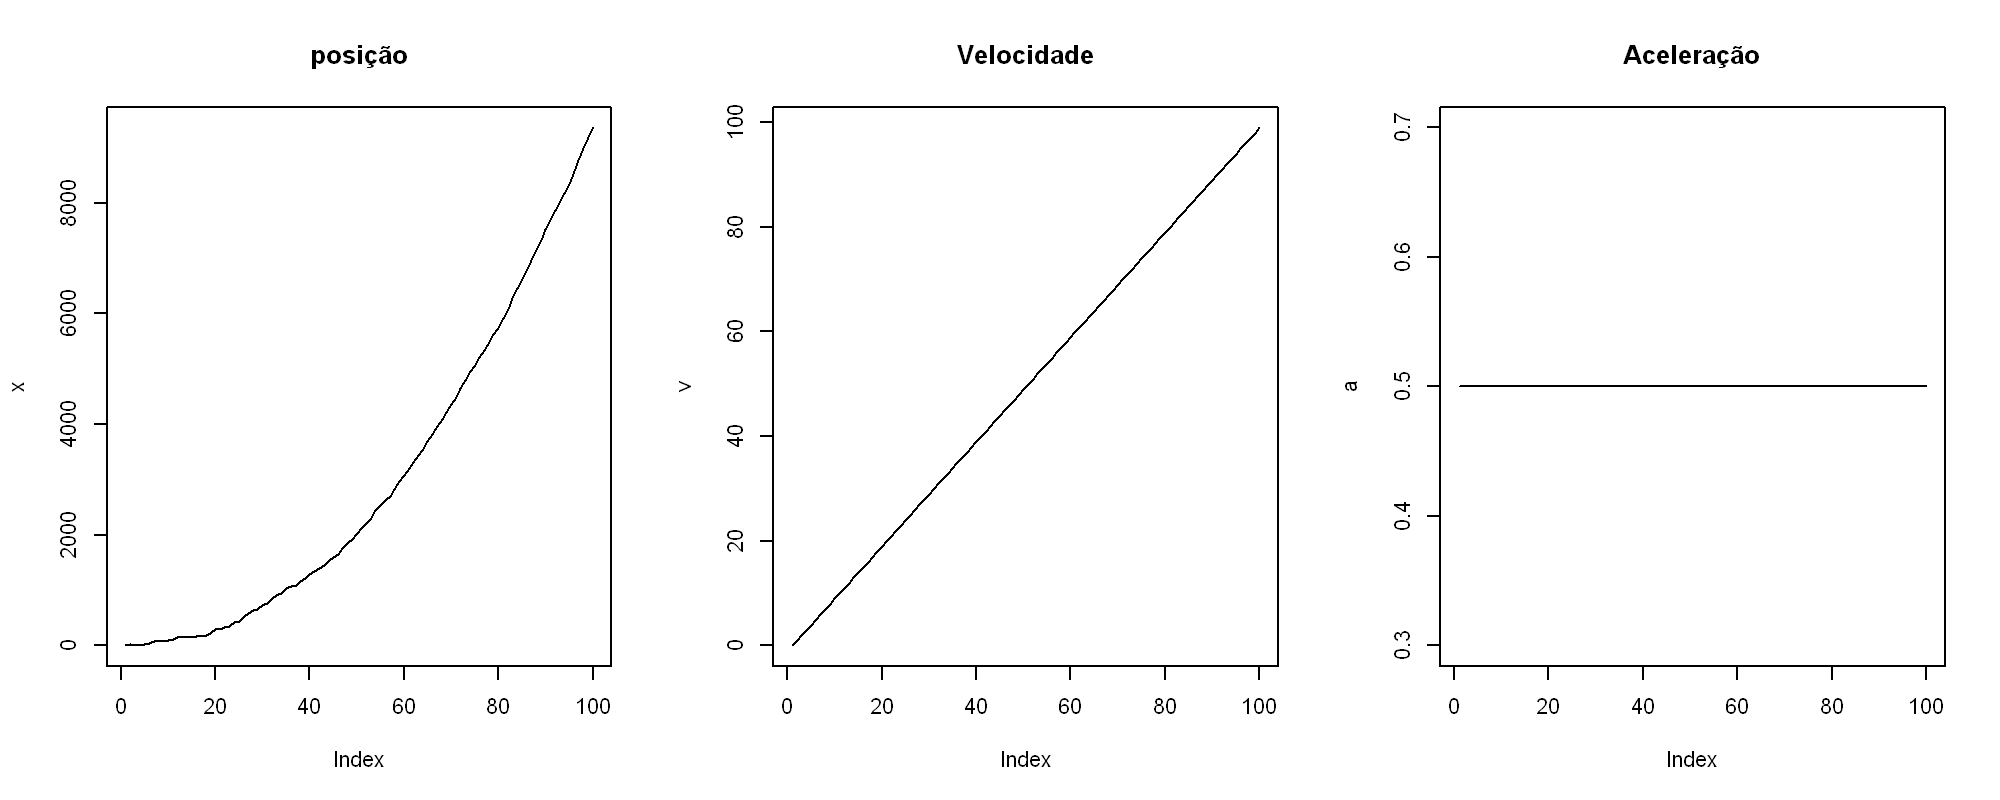

In [15]:
par(bg = 'white', mfrow = c(1, 3))
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)

plot(x, main = "posição"   , type='l')
plot(v, main = 'Velocidade', type = 'l')
plot(a, main = 'Aceleração', type = 'l')



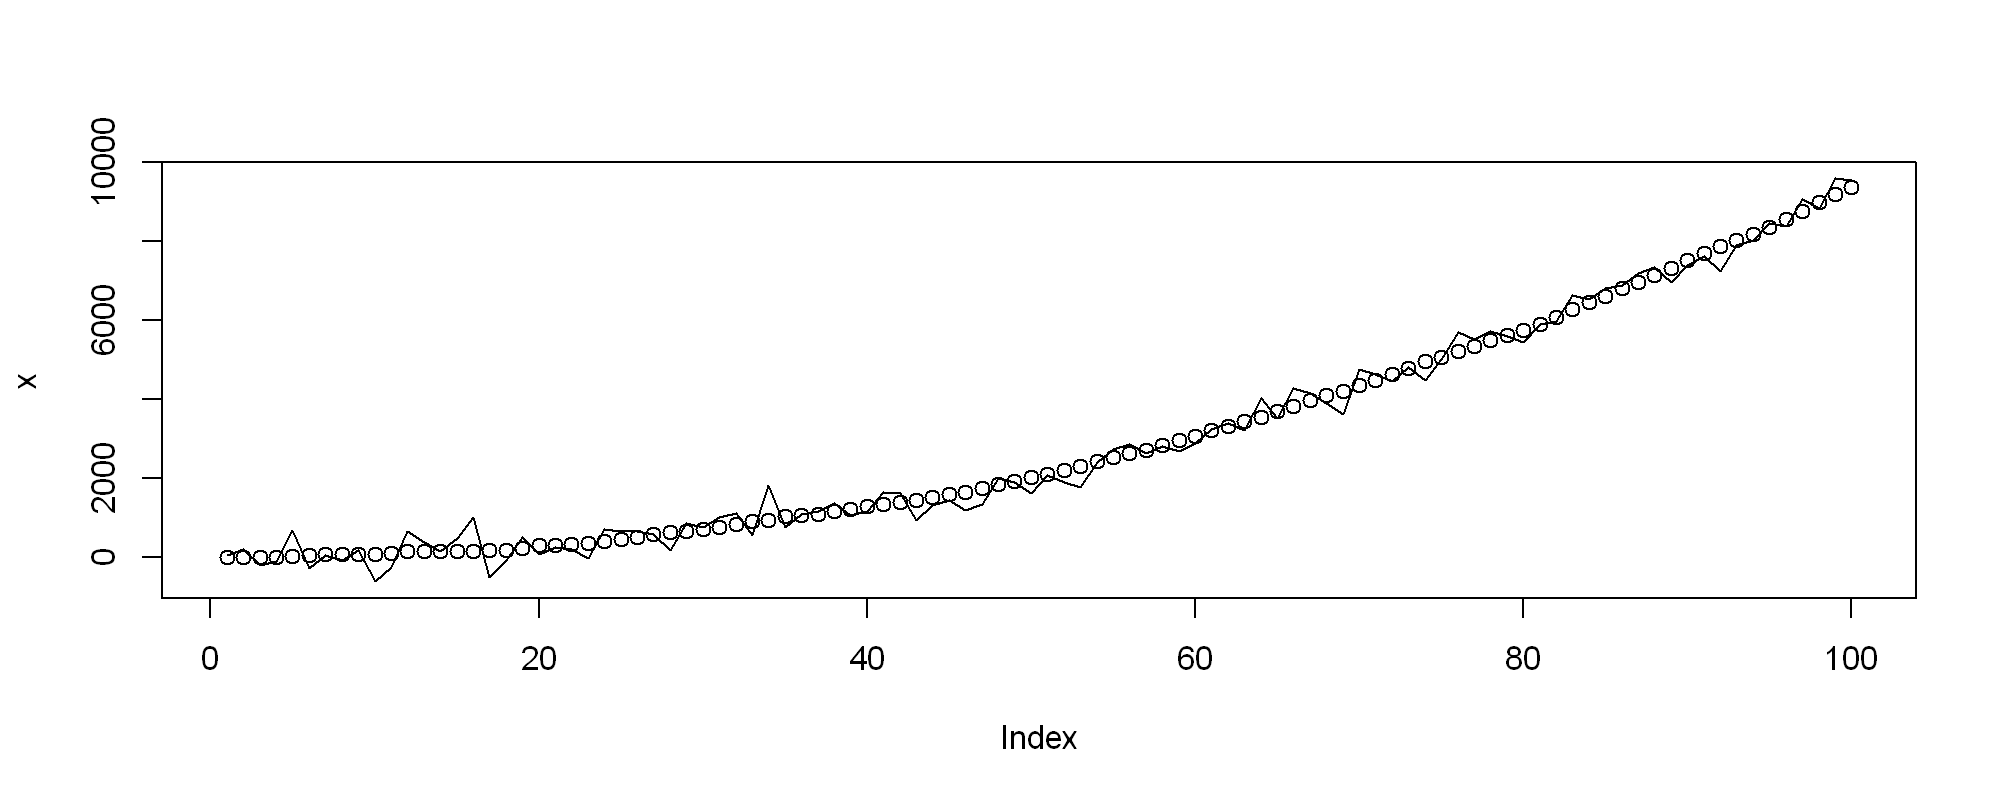

In [17]:
# Sensor

z = x + rnorm(ts.length, sd = 300)

par(bg = 'white')
plot(x, ylim=range(c(x, z)))
lines(z)

Aplicando filtro de Kalman

In [34]:
kalman.motion = function(z, Q, R, A, H) {
    dim.state = dim(Q)[1]

    x.hat.minus = array(
        rep(0, ts.length * dim.state), 
        c(ts.length, dim.state)
    )
    x.hat = array(
        rep(0, ts.length * dim.state), 
        c(ts.length, dim.state)
    )

    p.minus = array(
        rep(0, ts.length * dim.state * dim.state), 
        c(ts.length, dim.state, dim.state)
    )
    P = array(
        rep(0, ts.length * dim.state * dim.state), 
        c(ts.length, dim.state, dim.state)
    ) 

    K = array(
        rep(0, ts.length * dim.state), 
        c(ts.length, dim.state)
    )

    # Estimativas iniciais = começãndo em 0 pra todas as métricas

    x.hat[1, ] = rep(0, dim.state)
    P[1, ,] = diag(dim.state)


    for (k in 2:ts.length){
        # Atualização do tempo
        x.hat.minus[k, ] = A %*% matrix(x.hat[k-1, ])
        p.minus[k, ,] = A %*% P[k-1, , ] %*% t(A) + Q

        K[k, ] = p.minus[k, ,] %*% H %*% solve(t(H) %*% p.minus[k, ,] %*% H + R)
        x.hat[k, ] = x.hat.minus[k, ] + K[k, ] %*% (z[k] - t(H) %*% x.hat.minus[k, ])
        P[k, , ] = (diag(dim.state) - K[k,] %*% t(H)) %*% p.minus[k, , ]
    }
    return(list(xhat = x.hat, x.hatminus = x.hat.minus))
}

In [35]:
R = 10^2
Q = 10 
A = matrix(1) ## x_t = A * x_t - 1 (how prior x affects later x)
H = matrix(1) ## y_t = H * x_t     (translating state to measurement)

In [36]:
## run the data through the Kalman filtering method
xhat = kalman.motion(z, diag(1) * Q, R, A, H)[[1]]
xhatminus = kalman.motion(z, diag(1) * Q, R, A, H)[[2]]

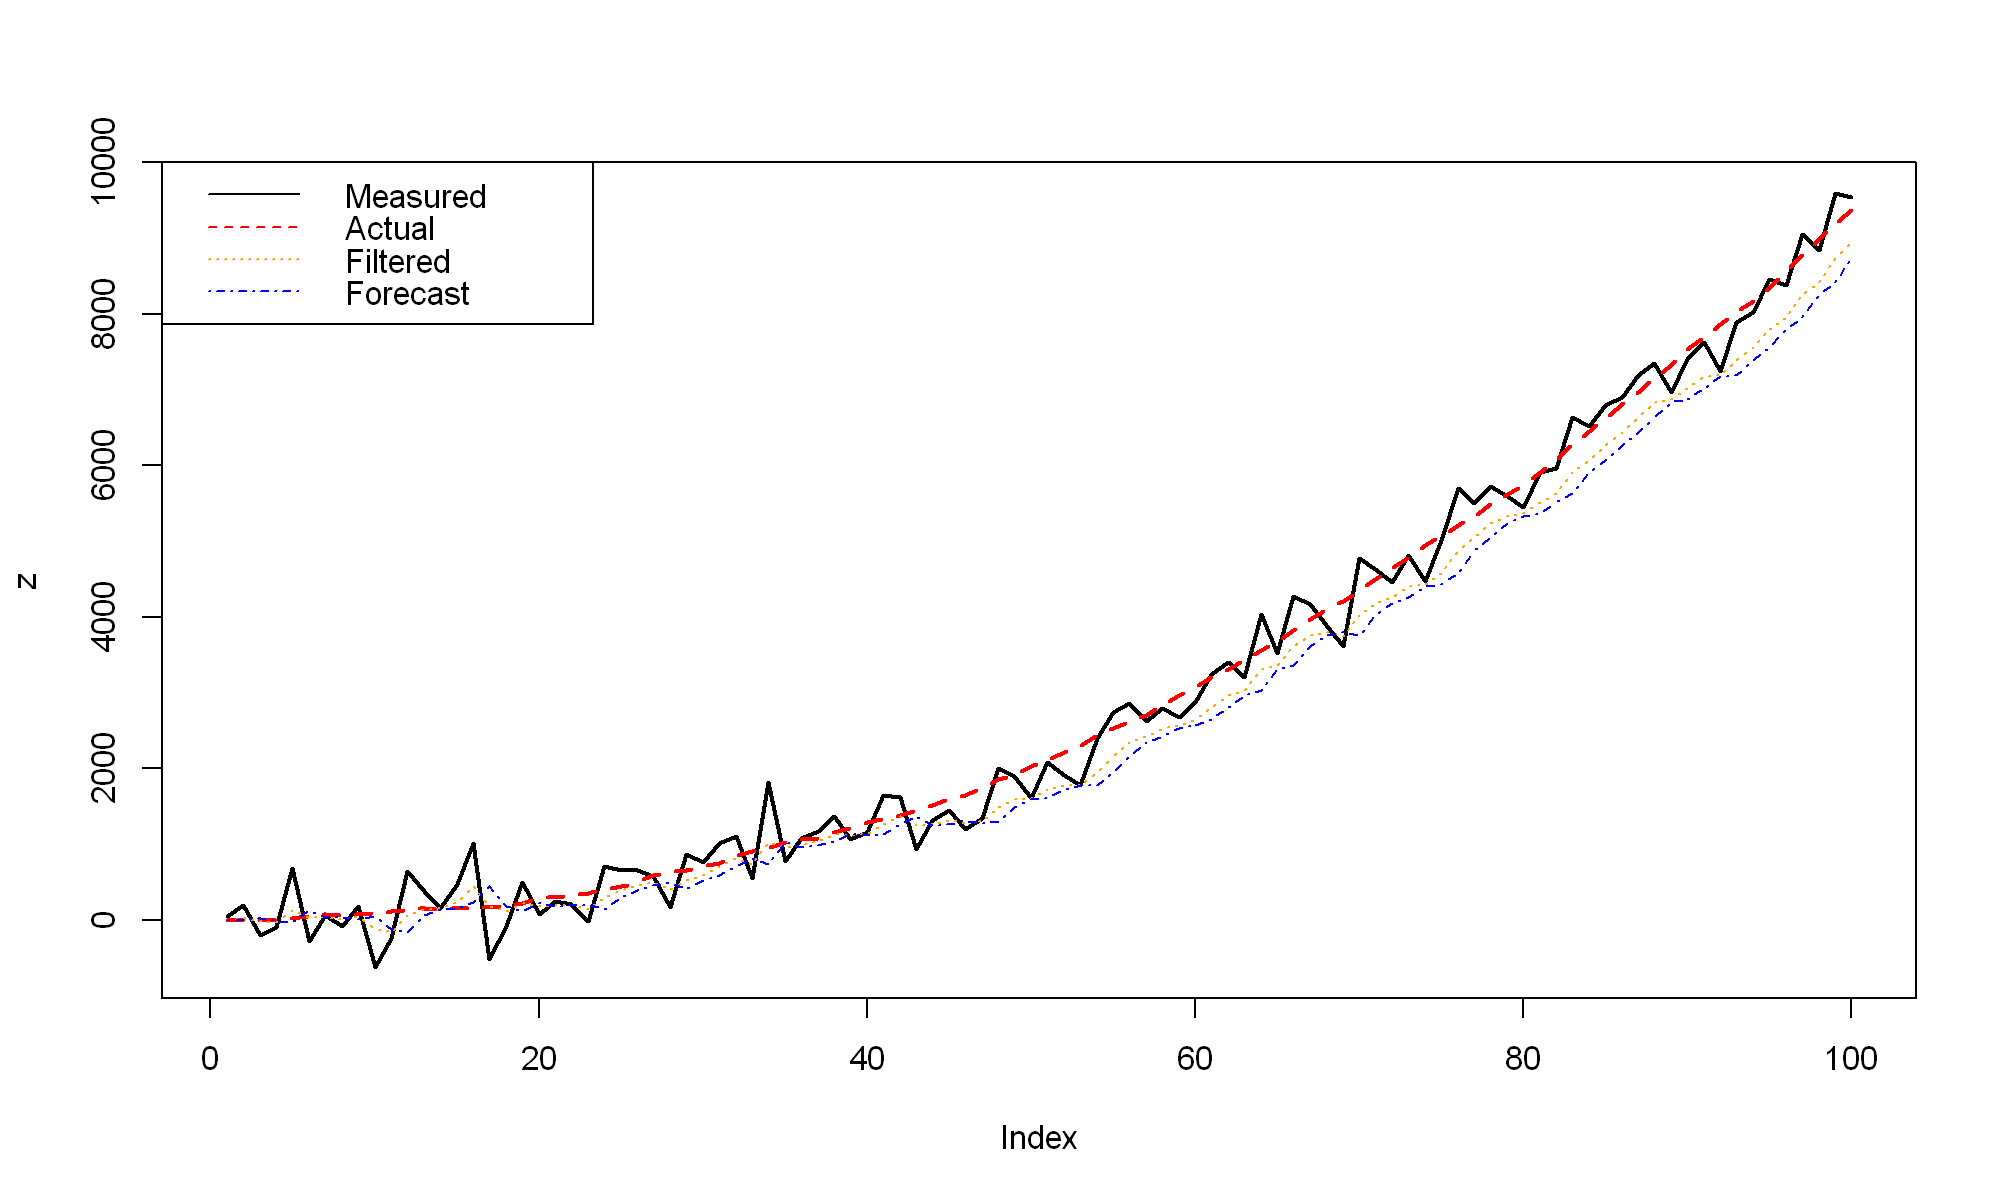

In [41]:
par(bg = 'white')
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)
## visualization
plot(z, ylim = range(c(x, z)), type = 'l',
                 col = "black",  lwd = 2)
lines(x,         col = "red",    lwd = 2, lty = 2)
lines(xhat,      col = "orange", lwd = 1, lty = 3)
lines(xhatminus, col = "blue",   lwd = 1, lty = 4)
legend("topleft", 
       legend = c("Measured", "Actual", "Filtered", "Forecast"),
       col = c("black", "red", "orange", "blue"), 
       lty = 1:4)

## Series temporais estruturais bayesianas

Estão relacionadas ao modelo gaussiano linear que usamos anteriormente com a filtragem de kalman. A principal diferença é que as séries temporais estruturais bayesianas forneecem uma maneira de usar componentes preexistentes para criar modelos mais complexos, que podem retratar fatos desconhecidos ou hipoteses interessantes sobre um sistema.

In [48]:
require(bsts)

In [49]:
elec = fread('dataset/electricity.csv')

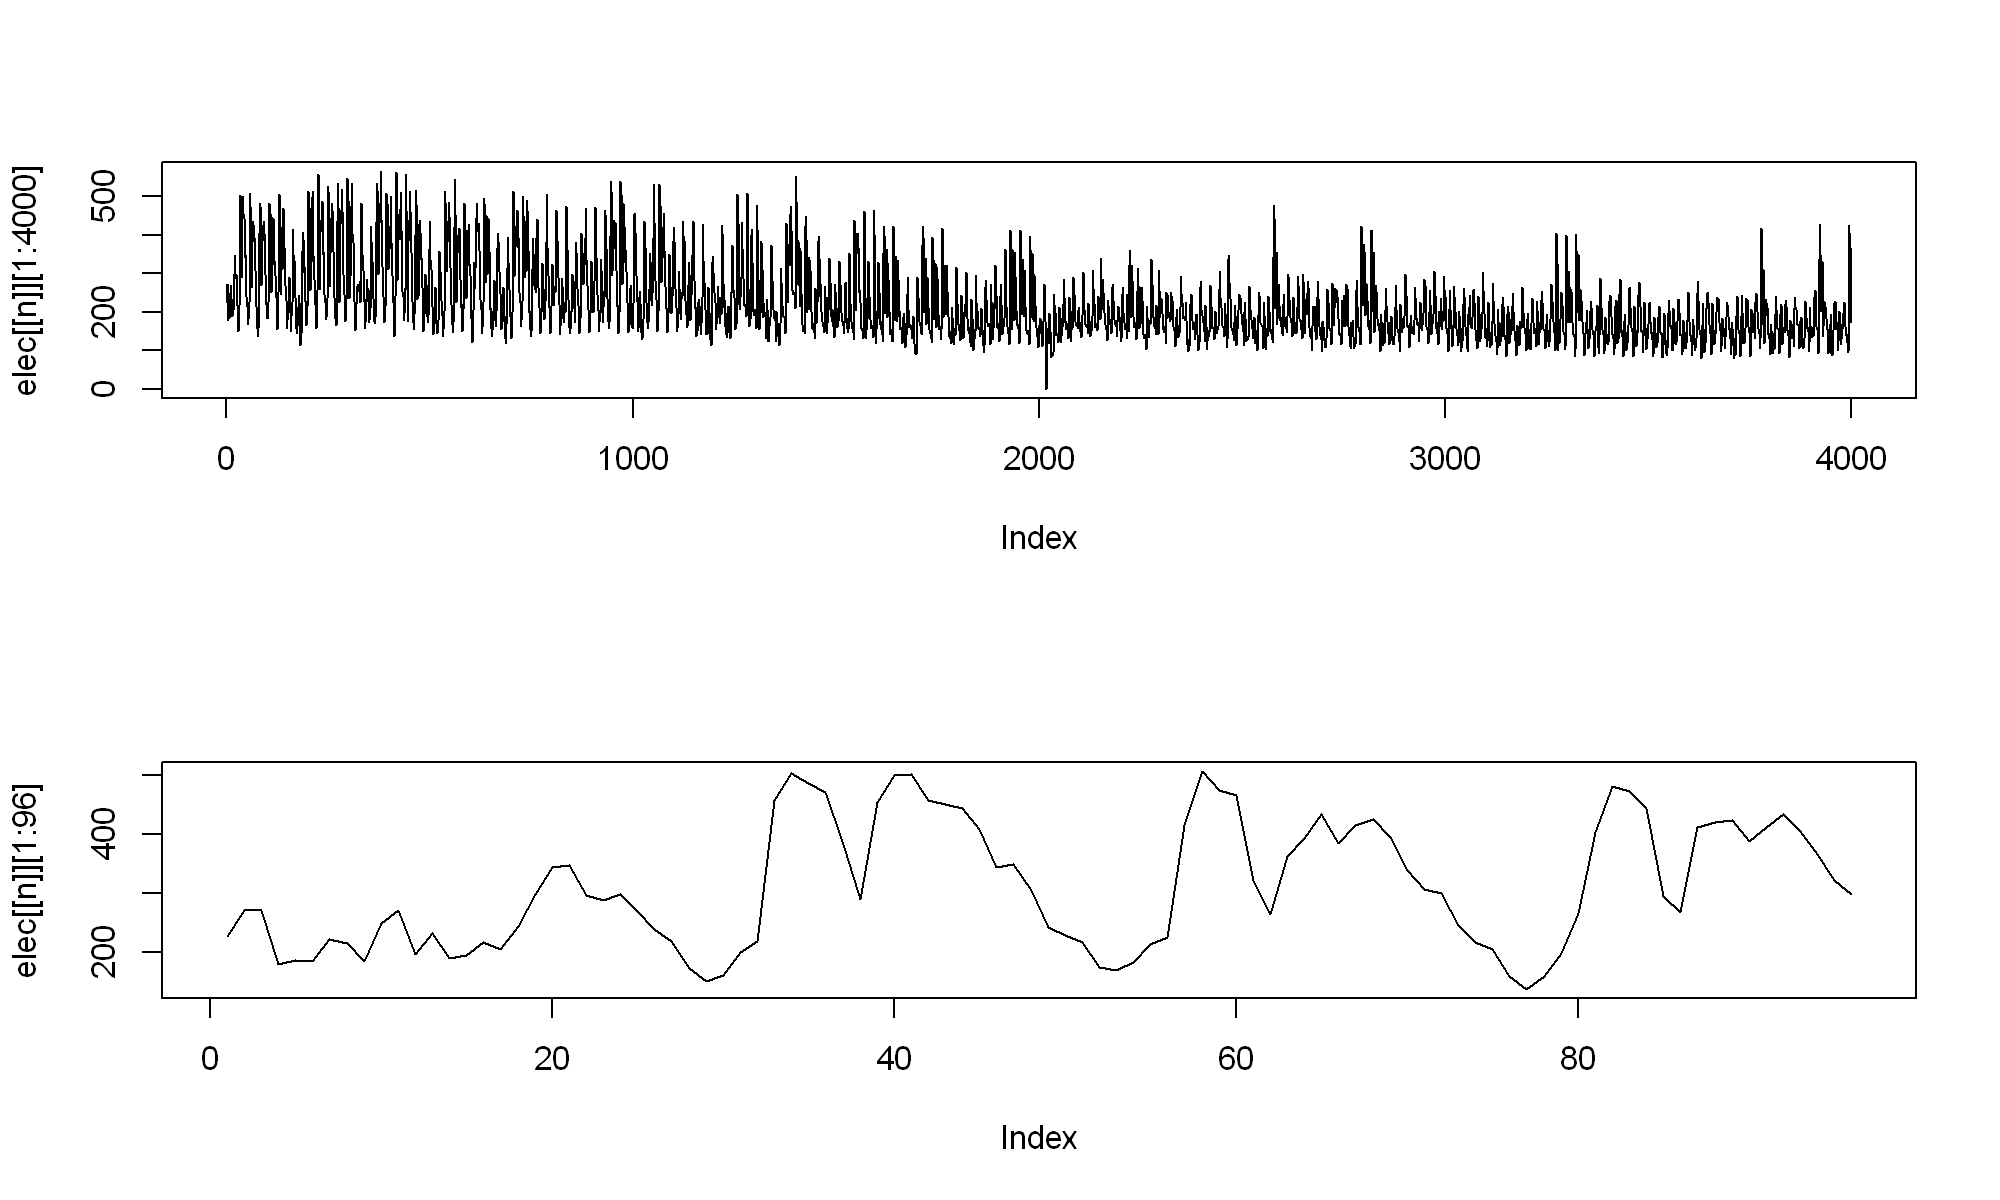

In [54]:
par(bg = 'white', mfrow=c(2, 1))
n = colnames(elec)[9]
plot(elec[[n]][1:4000], type = 'l')
plot(elec[[n]][1:96], type = 'l')


In [55]:
ss = AddLocalLinearTrend(list(), elec[[n]])
ss = AddSeasonal(ss, elec[[n]], nseasons = 24, season.duration = 1)
ss = AddSeasonal(ss, elec[[n]], nseasons = 7, season.duration = 24)

In [58]:
model.1 = bsts(elec[[n]], state.specification = ss, niter = 100)

=-=-=-=-= Iteration 0 Mon Aug 18 20:00:18 2025
 =-=-=-=-=
=-=-=-=-= Iteration 10 Mon Aug 18 20:00:41 2025
 =-=-=-=-=
=-=-=-=-= Iteration 20 Mon Aug 18 20:01:08 2025
 =-=-=-=-=
=-=-=-=-= Iteration 30 Mon Aug 18 20:01:32 2025
 =-=-=-=-=
=-=-=-=-= Iteration 40 Mon Aug 18 20:01:43 2025
 =-=-=-=-=
=-=-=-=-= Iteration 50 Mon Aug 18 20:02:06 2025
 =-=-=-=-=
=-=-=-=-= Iteration 60 Mon Aug 18 20:02:22 2025
 =-=-=-=-=
=-=-=-=-= Iteration 70 Mon Aug 18 20:02:32 2025
 =-=-=-=-=
=-=-=-=-= Iteration 80 Mon Aug 18 20:02:44 2025
 =-=-=-=-=
=-=-=-=-= Iteration 90 Mon Aug 18 20:03:05 2025
 =-=-=-=-=


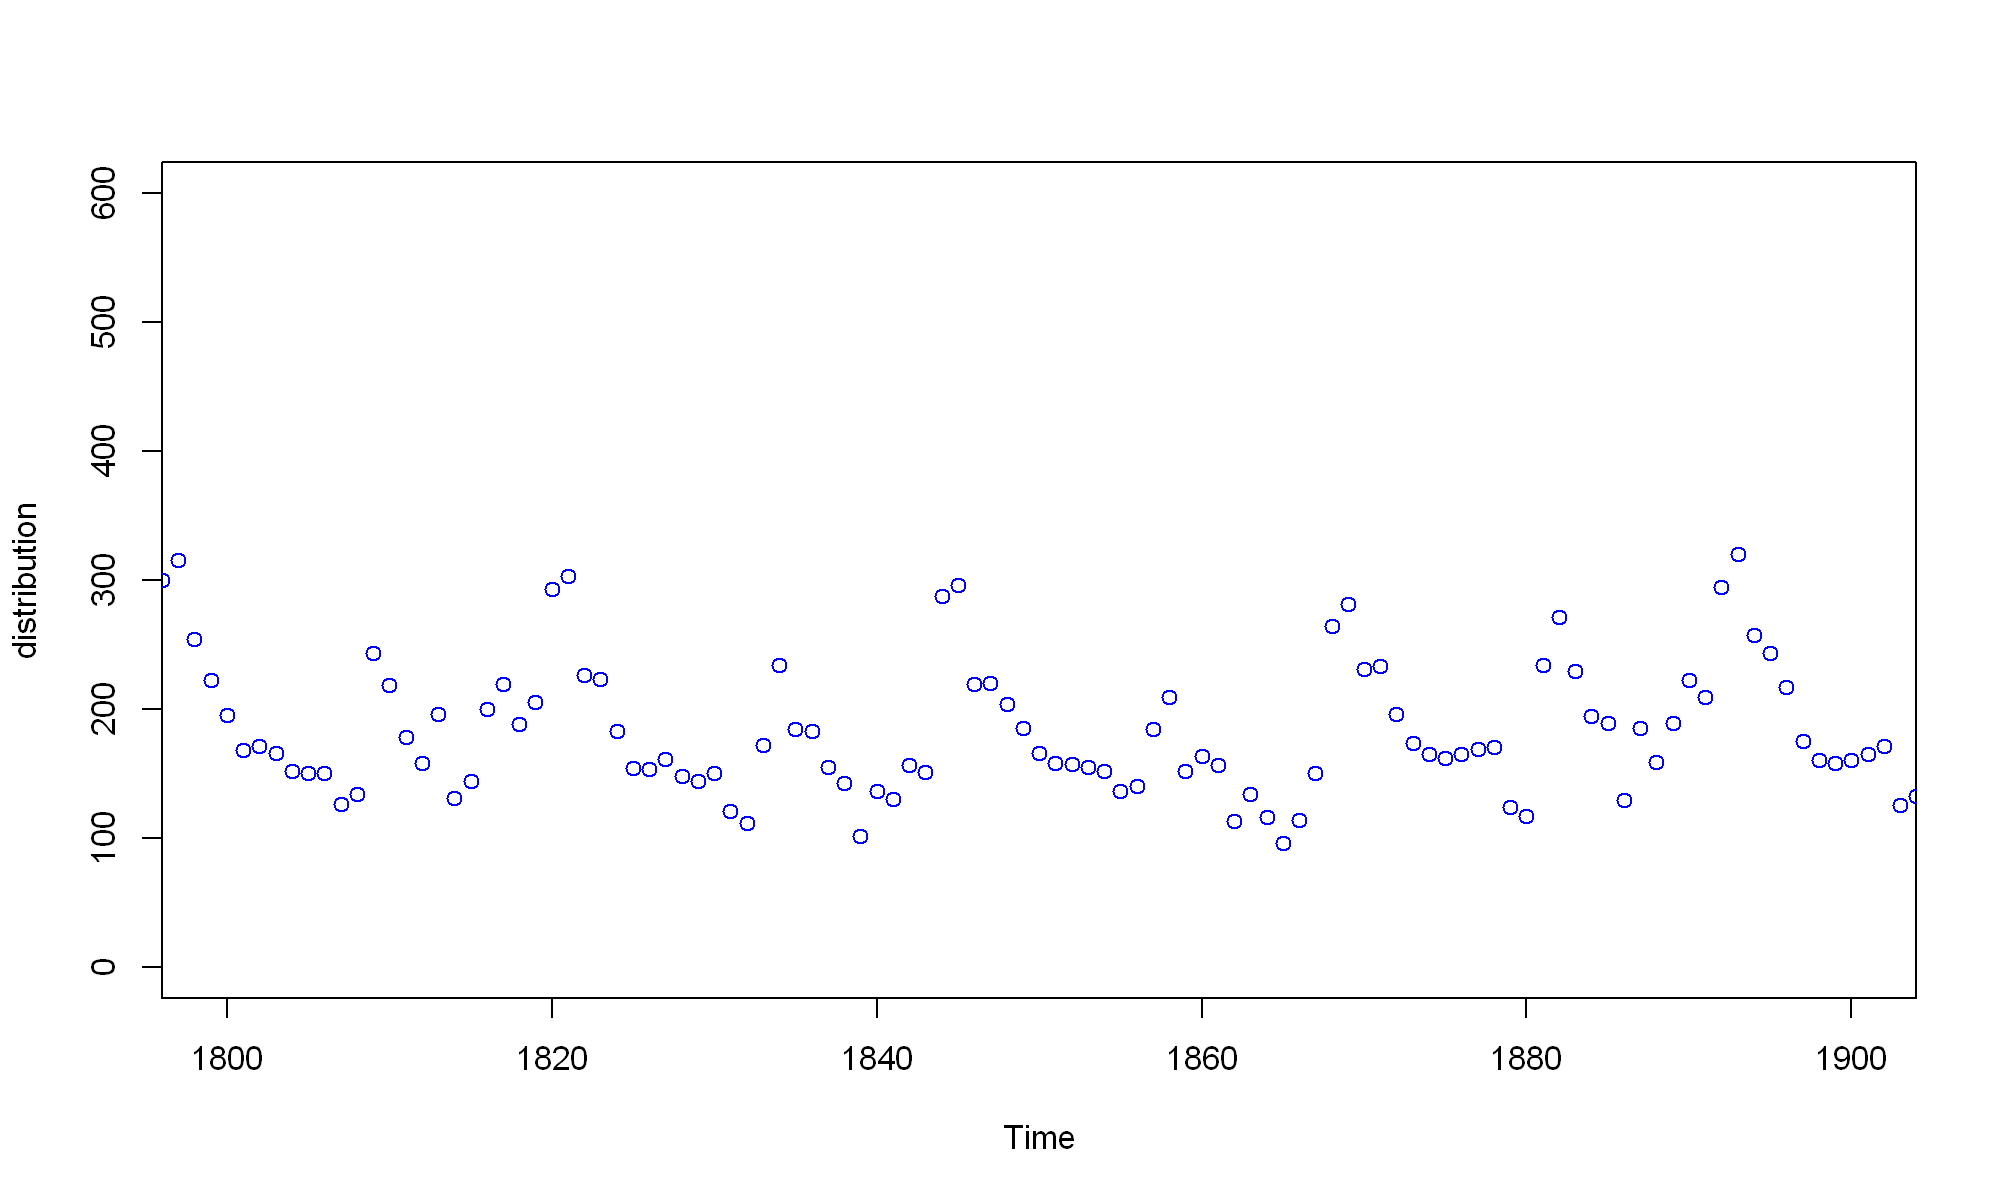

In [59]:
par(bg = 'white')
plot(model.1, xlim = c(1800, 1900))

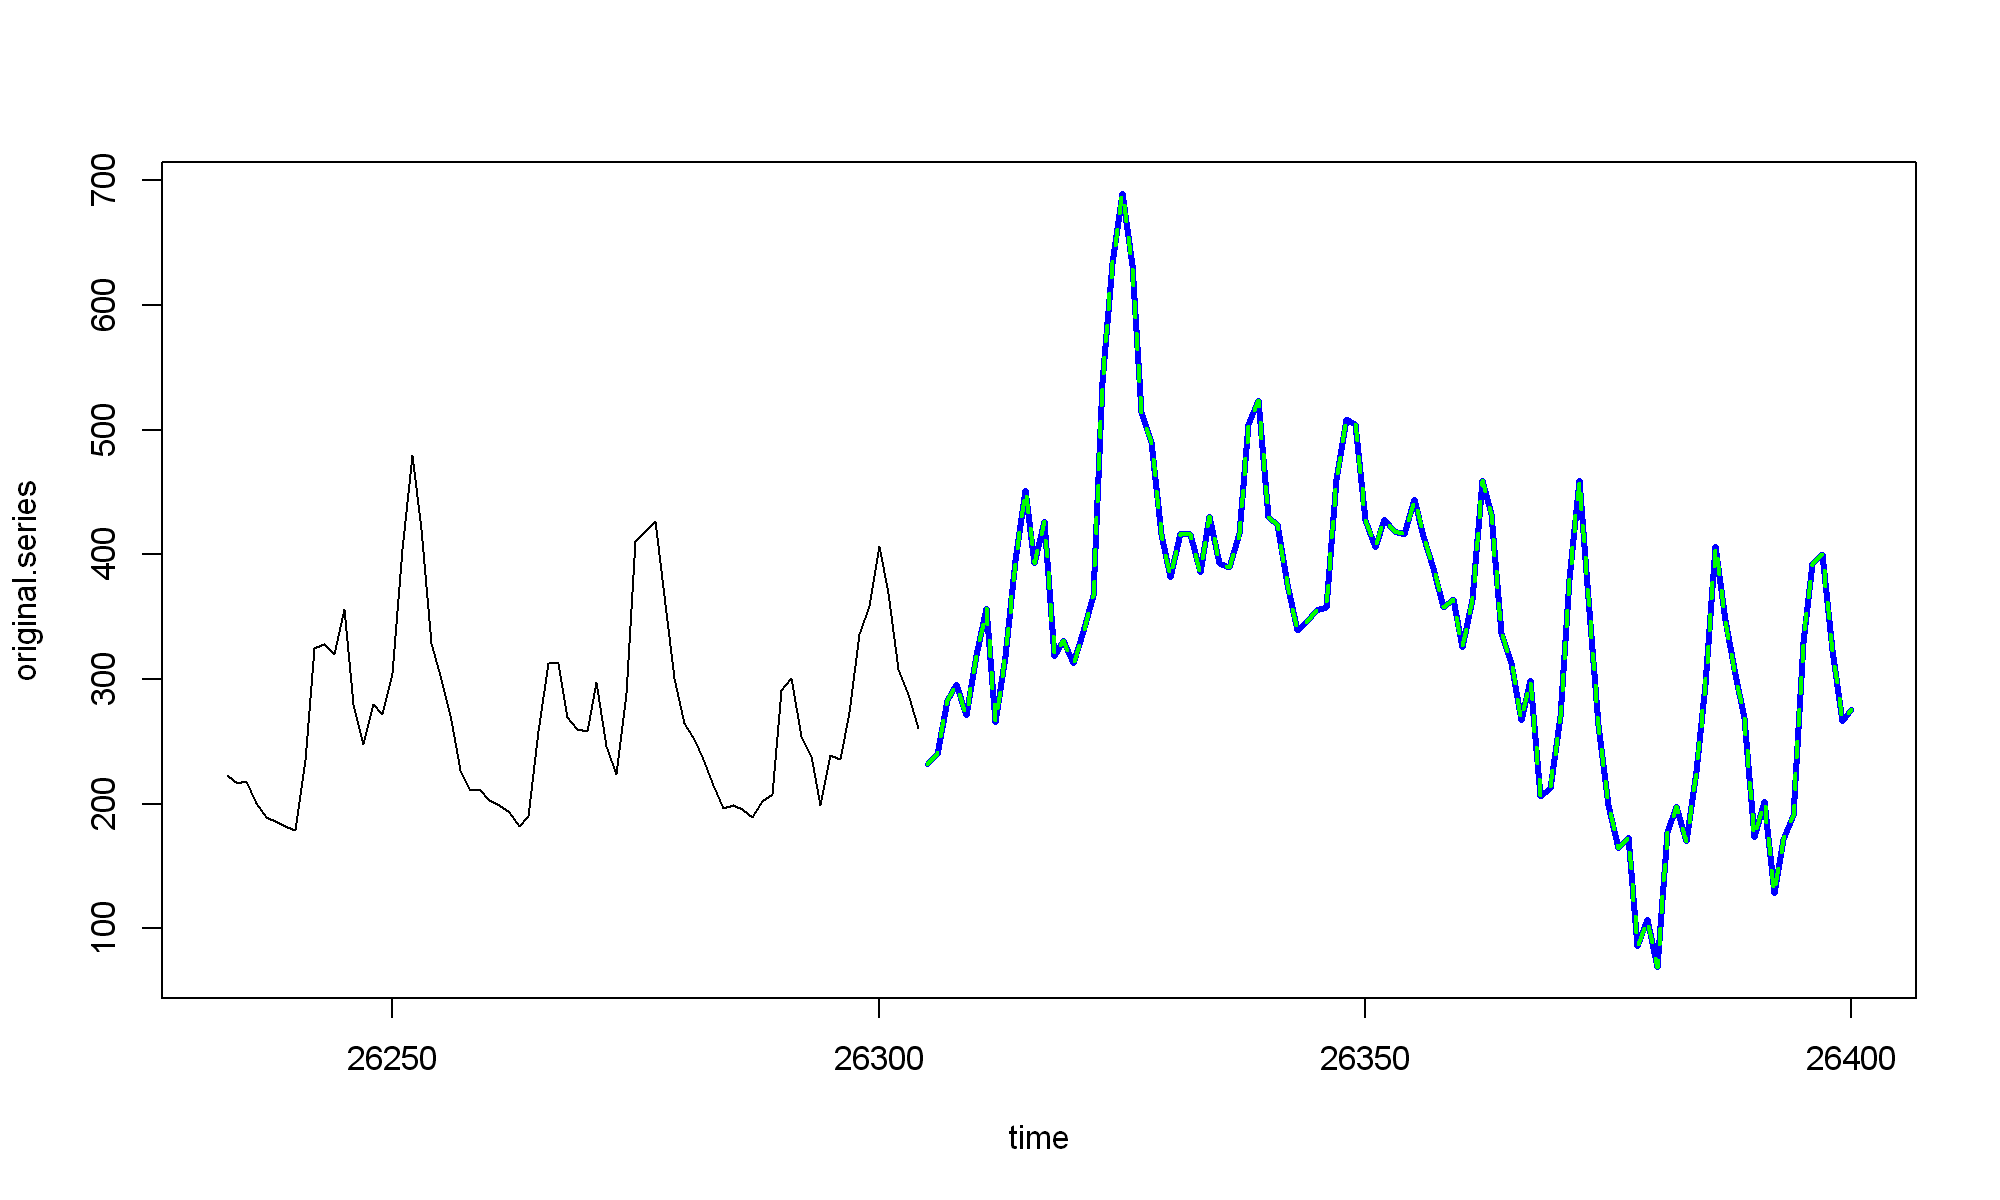

In [62]:
pred = predict(model.1, horizon = 96)
par(bg = 'white')
plot(pred, plot.original = 72)

> BSTS é custozo computacionamente